# Grab-Microsoft Challenge 
## Traffic Management

- geohash6: geohash is a public domain geocoding system which encodes a geographic location into a short string of letters and digits with arbitrary precision. You are free to use any geohash library to encode/decode the geohashes into latitude and longitude or vice versa.(Examples:https://github.com/hkwi/python-geohash)
- day: the value indicates the sequential order and not a particular day of the month
- timestamp: start time of 15-minute intervals in the following format: <hour>:<minute>, where hour ranges from 0 to 23 and minute is either one of (0, 15, 30, 45)
- demand: aggregated demand normalised to be in the range [0,1]
    
## Problem Statements:
- Which areas have high / low traffic demand?
- How does regional traffic demand change according to day / time?
- Forecast the travel demand for next 15min / 1hour and predict areas with high travel demand

### This is train LSTM model 

#### Import python library

In [2]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt

# plot matplotlib graph
%matplotlib inline

#Import models from scikit learn module:
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, LSTM, BatchNormalization
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

import h5py
import sklearn.metrics as metrics
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model 

import pickle
import joblib


In [33]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Define Variables

In [3]:
seed = 7
np.random.seed(seed)
modelname   = 'LSTM1-5in3out'
batch_size  = 8192
no_of_epoch = 18
no_of_train = 0.8

# choose a number of time steps
n_steps_in, predict_next_no_of_output = 5, 3

### Define Function

In [35]:
def createModel(): 
    inputs  = Input(shape=(X_train.shape[1],X_train.shape[2]))
    y = LSTM(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(inputs)
    y = BatchNormalization()(y)
    y = LSTM(128, return_sequences=True, dropout=0.3,recurrent_dropout=0.3)(y)
    y = BatchNormalization()(y)
    y = LSTM(units=256, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)(inputs)
    y = BatchNormalization()(y)
    y = LSTM(128, return_sequences=True, dropout=0.5,recurrent_dropout=0.5)(y)
    y = BatchNormalization()(y)
    y = LSTM(128, dropout=0.5,recurrent_dropout=0.5)(y)
    y = BatchNormalization()(y)
    y = Dense(predict_next_no_of_output, activation='sigmoid')(y)
  
    model = Model(inputs=inputs,outputs=y)
    model.compile(loss='mse',optimizer='adam', metrics=['mse', 'mae'])
    return model

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

#### Reading from Preprocessed

In [36]:
xls  = pd.ExcelFile('data/Dataset_feature.xlsx')
data = pd.read_excel(xls, 'TrafficMgmt')
data

,day,hour,min,dow,lat,long,demand
0,0.283333,0.869565,0.000000,0.666667,0.533333,0.171429,0.020072
1,0.150000,0.608696,0.666667,0.500000,0.288889,0.200000,0.024721
2,0.133333,0.260870,0.333333,0.333333,0.644444,0.828571,0.102821
3,0.516667,0.217391,0.000000,0.666667,0.533333,0.428571,0.088755
4,0.233333,0.173913,0.000000,0.166667,0.288889,0.342857,0.074468
...,...,...,...,...,...,...,...
1048570,0.083333,0.347826,0.666667,1.000000,0.911111,0.771429,0.024022
1048571,0.366667,0.652174,0.666667,0.333333,0.111111,0.400000,0.005703
1048572,0.683333,0.652174,1.000000,0.000000,0.533333,0.200000,0.067131
1048573,0.016667,0.260870,0.666667,0.333333,0.711111,0.600000,0.151323


In [37]:
predictor_var = ['day', 'hour', 'min', 'dow', 'lat', 'long']
outcome_var   = 'demand'
no_of_features = len(predictor_var)

#### Prepare training & test data
- Since this is a time series dataset, we can try using LSTM 

In [38]:
dataset = data.to_numpy()

In [39]:
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, predict_next_no_of_output)
print(X.shape, y.shape)

(1048569, 5, 6) (1048569, 3)


#### Train-test-val dataset split

In [40]:
X_train1 = X[:int(no_of_train*len(X))]
y_train1 = y[:int(no_of_train*len(X))]
X_test  = X[int(no_of_train*len(X)):]
y_test  = y[int(no_of_train*len(X)):]

X_train = X_train1[:int(no_of_train*len(X_train1))]
y_train = y_train1[:int(no_of_train*len(X_train1))]
X_val   = X_train1[int(no_of_train*len(X_train1)):]
y_val   = y_train1[int(no_of_train*len(X_train1)):]

In [41]:
print(X_train.shape, y_train.shape,X_test.shape, y_test.shape,X_val.shape, y_val.shape)

(671084, 5, 6) (671084, 3) (209714, 5, 6) (209714, 3) (167771, 5, 6) (167771, 3)


<h2><center>Create Model and test</center><h2>

<h3>LSTM<h3>

In [42]:
model = createModel()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 6)]            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 256)            269312    
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 256)            1024      
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 128)            197120    
_________________________________________________________________
batch_normalization_3 (Batch (None, 5, 128)            512       
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512   

In [43]:
model.compile(loss='mse',optimizer='adam', metrics=['mse', 'mae'])

In [44]:
# Create checkpoints to save model during training and save training data into csv
# ‘monitor’ can be ‘val_acc’ or ‘val_loss’
# When set to ‘val_acc’, ‘mode’ must be ‘max’; when set to ‘val_loss’, ‘mode’ must be ‘min’

filepath       = modelname + ".hdf5"
checkpoint     = ModelCheckpoint(filepath, monitor='val_loss',verbose=0,save_best_only=True,mode='min') 
csv_logger     = CSVLogger(modelname + '.csv')
callbacks_list = [checkpoint,csv_logger]

In [45]:
# The line for training
hisgtory = model.fit(X_train, 
                     y_train, 
                     validation_data=(X_val, y_val), 
                     epochs=no_of_epoch, 
                     batch_size=batch_size,
                     shuffle=False,
                     callbacks=callbacks_list) 

Train on 671084 samples, validate on 167771 samples
Epoch 1/18
671084/671084 [==============================] - 71s 106us/sample - loss: 0.1320 - mse: 0.1320 - mae: 0.3212 - val_loss: 0.0392 - val_mse: 0.0392 - val_mae: 0.1715
Epoch 2/18
671084/671084 [==============================] - 59s 88us/sample - loss: 0.0302 - mse: 0.0302 - mae: 0.1242 - val_loss: 0.0252 - val_mse: 0.0252 - val_mae: 0.0979
Epoch 3/18
671084/671084 [==============================] - 54s 81us/sample - loss: 0.0257 - mse: 0.0257 - mae: 0.0984 - val_loss: 0.0252 - val_mse: 0.0252 - val_mae: 0.0951
Epoch 4/18
671084/671084 [==============================] - 54s 81us/sample - loss: 0.0255 - mse: 0.0255 - mae: 0.0969 - val_loss: 0.0252 - val_mse: 0.0252 - val_mae: 0.0969
Epoch 5/18
671084/671084 [==============================] - 54s 81us/sample - loss: 0.0254 - mse: 0.0254 - mae: 0.0970 - val_loss: 0.0252 - val_mse: 0.0252 - val_mae: 0.0967
Epoch 6/18
671084/671084 [==============================] - 54s 81us/sample -

### Test dataset test result

In [47]:
predicted_value = model.predict(X_test)
print(mean_squared_error(y_test,predicted_value))

0.025251894683873687


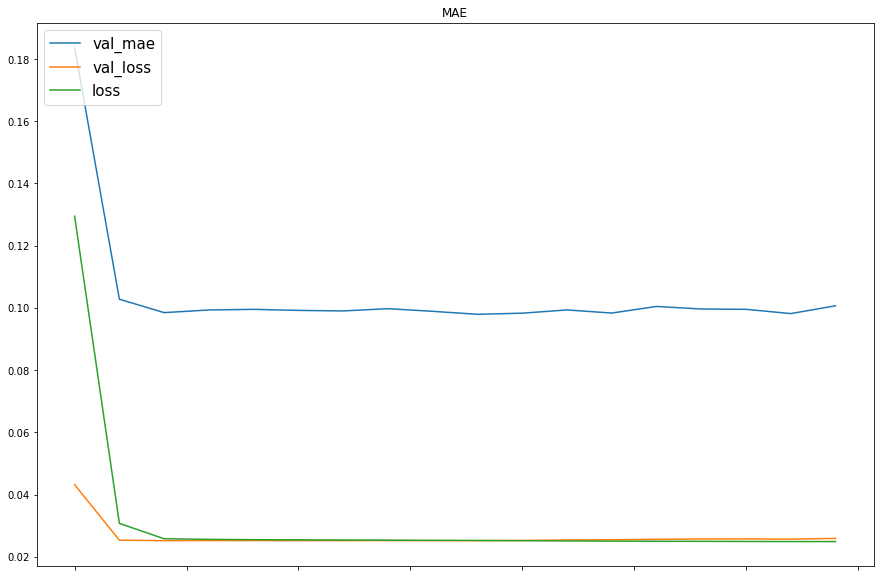

In [4]:
records     = pd.read_csv(modelname +'.csv')
plt.figure(figsize=(15,10))

ax          = plt.gca()
ax.set_xticklabels([])

plt.plot(records['val_mae'],label="val_mae")
plt.plot(records['val_loss'],label="val_loss")
plt.plot(records['loss'],label="loss")
plt.title('MAE',fontsize=12)
plt.legend(loc="upper left",fontsize=15)

plt.show()



### Load save LSTM model

In [49]:
# Load your own trained model
model = load_model(filepath, compile = False)

### Sample Testing 

In [50]:
scaler_filename = "grab_msft_scaler.save"
scaler          = joblib.load(scaler_filename) 

#### First set of testdata

In [51]:
xls  = pd.ExcelFile('data/test_sample.xlsx')
test_sample = pd.read_excel(xls, 'TrafficMgmt')

# Apply Standardscalar to sample test data
test_sample[predictor_var] = scaler.fit_transform(test_sample[predictor_var])

In [52]:
# covert into input/output
test_sample_array = test_sample.to_numpy()
X_sample, y_sample = split_sequences(test_sample_array, n_steps_in, predict_next_no_of_output)
print(X_sample.shape, y_sample.shape)

(15, 5, 6) (15, 3)


In [53]:
predicted_value = model.predict(X_sample)
print('Predicted value : {} \n Actual Value    : {}' .format(predicted_value,y_sample))

Predicted value : [[0.1105629  0.10818288 0.10927291]
 [0.1093549  0.10065707 0.10302172]
 [0.09947684 0.10170865 0.09809824]
 [0.10261864 0.10292061 0.10190861]
 [0.10497595 0.10141284 0.09775209]
 [0.10443018 0.10138997 0.09765065]
 [0.09556271 0.10114247 0.09786125]
 [0.0997729  0.10171793 0.09824719]
 [0.10276376 0.10195579 0.09832101]
 [0.08130633 0.10145276 0.09830381]
 [0.11187552 0.1003793  0.10240466]
 [0.1049492  0.10163235 0.09784052]
 [0.10484001 0.10213864 0.09805538]
 [0.11225171 0.10065658 0.10245482]
 [0.0962375  0.10119802 0.09778712]] 
 Actual Value    : [[0.3412908  0.36364563 0.00339634]
 [0.36364563 0.00339634 0.17591761]
 [0.00339634 0.17591761 0.22734446]
 [0.17591761 0.22734446 0.03213684]
 [0.22734446 0.03213684 0.0148439 ]
 [0.03213684 0.0148439  0.10047717]
 [0.0148439  0.10047717 0.21478451]
 [0.10047717 0.21478451 0.00904605]
 [0.21478451 0.00904605 0.03513281]
 [0.00904605 0.03513281 0.00620095]
 [0.03513281 0.00620095 0.03977563]
 [0.00620095 0.03977563 0

In [54]:
print(mean_squared_error(y_sample,predicted_value))

0.010734057710945141


### single sample test

In [58]:
xls  = pd.ExcelFile('data/test_sample8000.xlsx')
test_sample = pd.read_excel(xls, 'TrafficMgmt')
test_sample_array = test_sample.to_numpy()

In [59]:
# Apply Standardscalar to sample test data
test_sample[predictor_var] = scaler.fit_transform(test_sample[predictor_var])

In [60]:
test_sample_array = test_sample.to_numpy()
X_sample, y_sample = split_sequences(test_sample_array, n_steps_in, predict_next_no_of_output)
print(X_sample.shape, y_sample.shape)

(15, 5, 6) (15, 3)


In [63]:
X_sample[0].shape

(5, 6)

In [66]:
# Data input sequence format :
test_data1 = np.expand_dims(X_sample[0], axis=0)
test_data1.shape

(1, 5, 6)

In [69]:
# Data input sequence format :
test_data1  = [[0.14285714, 0.43478261, 0.66666667, 0.16666667, 0.97435897,0.92307692],
               [0.40816327, 0.04347826, 0.33333333, 0.        , 0.76923077,0.46153846],
               [0.06122449, 0.91304348, 0.66666667, 0.66666667, 0.35897436,0.65384615],
               [0.97959184, 0.30434783, 0.33333333, 0.        , 0.        ,0.07692308],
               [0.6122449 , 0.34782609, 0.33333333, 0.5       , 0.46153846,0.23076923]]
test_data2  = [[0.40816327, 0.04347826, 0.33333333, 0.        , 0.76923077,0.46153846],
               [0.06122449, 0.91304348, 0.66666667, 0.66666667, 0.35897436,0.65384615],
               [0.97959184, 0.30434783, 0.33333333, 0.        , 0.        ,0.07692308],
               [0.6122449 , 0.34782609, 0.33333333, 0.5       , 0.46153846,0.23076923],
               [0.6122449 , 0.13043478, 0.        , 0.5       , 0.46153846,0.5       ]]
test_data3  = [[0.06122449, 0.91304348, 0.66666667, 0.66666667, 0.35897436,0.65384615],
               [0.97959184, 0.30434783, 0.33333333, 0.        , 0.        ,0.07692308],
               [0.6122449 , 0.34782609, 0.33333333, 0.5       , 0.46153846,0.23076923],
               [0.6122449 , 0.13043478, 0.        , 0.5       , 0.46153846,0.5       ],
               [0.71428571, 0.95652174, 0.66666667, 0.16666667, 0.92307692,0.80769231]]
test_data4  = [[0.97959184, 0.30434783, 0.33333333, 0.        , 0.        ,0.07692308],
               [0.6122449 , 0.34782609, 0.33333333, 0.5       , 0.46153846,0.23076923],
               [0.6122449 , 0.13043478, 0.        , 0.5       , 0.46153846,0.5       ],
               [0.71428571, 0.95652174, 0.66666667, 0.16666667, 0.92307692,0.80769231],
               [0.2244898 , 0.30434783, 0.        , 0.83333333, 0.12820513,0.15384615]]
test_data5  = [[0.6122449 , 0.34782609, 0.33333333, 0.5       , 0.46153846,0.23076923],
               [0.6122449 , 0.13043478, 0.        , 0.5       , 0.46153846,0.5       ],
               [0.71428571, 0.95652174, 0.66666667, 0.16666667, 0.92307692,0.80769231],
               [0.2244898 , 0.30434783, 0.        , 0.83333333, 0.12820513,0.15384615],
               [0.34693878, 0.30434783, 0.        , 0.66666667, 0.79487179,1.        ]]

test_data1 = np.expand_dims(test_data1, axis=0)
test_data2 = np.expand_dims(test_data2, axis=0)
test_data3 = np.expand_dims(test_data3, axis=0)
test_data4 = np.expand_dims(test_data4, axis=0)
test_data5 = np.expand_dims(test_data5, axis=0)

test_target1 = [0.15961478, 0.909941638, 0.000901061]
test_target2 = [0.15961478, 0.909941638, 0.000901061]
test_target3 = [0.00090106, 0.132621550, 0.193137870]
test_target4 = [0.13262155, 0.193137870, 0.040869690]
test_target5 = [0.19313787, 0.040869690, 0.020427850]

In [70]:
predicted_value = model.predict(test_data1)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target1))

Predicted value : [[0.11458825 0.10155618 0.10347967]]
Actual Value    : [0.15961478, 0.909941638, 0.000901061]


In [71]:
predicted_value = model.predict(test_data2)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target2))

Predicted value : [[0.11387951 0.10133145 0.10325343]]
Actual Value    : [0.15961478, 0.909941638, 0.000901061]


In [73]:
predicted_value = model.predict(test_data3)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target3))

Predicted value : [[0.09023068 0.10023664 0.10184264]]
Actual Value    : [0.00090106, 0.13262155, 0.19313787]


In [74]:
predicted_value = model.predict(test_data4)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target4))

Predicted value : [[0.11160884 0.10158009 0.10318433]]
Actual Value    : [0.13262155, 0.19313787, 0.04086969]


In [75]:
predicted_value = model.predict(test_data5)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target5))

Predicted value : [[0.1091318  0.10344008 0.10584064]]
Actual Value    : [0.19313787, 0.04086969, 0.02042785]
